# Microbiome-metabolome interaction probabilities via [mmvec](https://github.com/biocore/mmvec) for cervicovaginal microenvironment

Notebook accompanies publication: "Multi-omics data integration reveals metabolome as the top predictor of the cervicovaginal microenvironment".

It includes the application of mmvec to derive the microbiome-metabolome interaction probabilities:             

[1) Import packages and set paths](#chap1)      

[2) Read datasets](#chap2)      

[3) Plot mmvec biplot](#chap3)      

[4) Plot mmvec heatmap](#chap4)            

      
**Beware: This notebook runs in a separate conda environment than the main notebook `MultiOmics-HPV.ipynb`.** For details on how to setup this environment please refer to the `README.md` file.
         

<a id='chap1'></a>

## 1) Import packages and set paths

In [6]:

import os
import pandas as pd
import qiime2
from qiime2.plugins import taxa, mmvec
from matplotlib.pylab import plt
import skbio
from util_mmvec import biplot_from_rhapsody

%matplotlib inline
%load_ext autoreload
%autoreload 2

# location to retrieve raw-data
path2data = 'data-raw'

# location to save outputs
output_dir = 'b-mmvec-output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id='chap2'></a>

## 2) Read datasets

In [7]:
# read metadata of metabolites
metabolite_md = qiime2.Metadata.load(
    os.path.join(path2data, 'metabolite_metadata_CC.txt'))

# load conditionals created with mmvec
df_conditionals = qiime2.Artifact.load(os.path.join(
    path2data, 'metab_ranks.qza')).view(pd.DataFrame)

# load pcoa created with mmvec
pcoa = qiime2.Artifact.load(os.path.join(path2data, 'metab_biplot.qza')).view(
    skbio.stats.ordination.OrdinationResults)

# load consensus taxonomy
path2merged_tax = os.path.join(path2data, 'merged_taxonomy.tsv')
merged_taxonomy = pd.read_csv(path2merged_tax, sep='\t')
merged_taxonomy.set_index('Feature ID', inplace=True)
taxonomy = merged_taxonomy[['Consensus Taxonomy']].copy(deep=True)
taxonomy.columns = ['Taxon']


<a id='chap3'></a>

## 3) Plot mmvec biplot

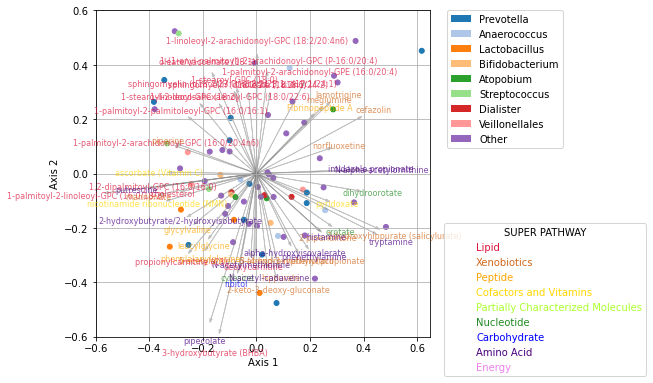

In [8]:
metabolite_colors = {
    'Lipid': 'crimson',
    'Xenobiotics': 'chocolate',
    'Peptide': 'orange',
    'Cofactors and Vitamins': 'gold',
    'Partially Characterized Molecules': 'greenyellow',
    'Nucleotide': 'forestgreen',
    'Carbohydrate': 'blue',
    'Amino Acid': 'indigo',
    'Energy': 'violet',
}
fig = biplot_from_rhapsody(pcoa, taxonomy, metabolite_md.to_dataframe()['SUPER PATHWAY'],
                           metabolite_colors, palette="tab20", level=5,
                           minradius=.1, label_level=6, feature_labels=None, mincount=3, whitelist=None)
axes = plt.gca()
plt.xlim(-0.6, 0.65)
plt.ylim(-0.6, 0.6)
fig.savefig(os.path.join(output_dir, 'rhapsody-biplot.pdf'),
            bbox_inches="tight")
fig.savefig(os.path.join(output_dir, 'rhapsody-biplot.png'),
            bbox_inches="tight")


<a id='chap4'></a>

## 4) Plot mmvec heatmap

In [9]:
# process conditionals
df_conditionals = df_conditionals[df_conditionals.max(axis=1) >= 1.2]
df_conditionals = df_conditionals[df_conditionals.columns[(
    df_conditionals >= 2).any()]]

# align tax and conditionals
taxonomy, df_conditionals = taxonomy[['Taxon']].align(
    df_conditionals, join='inner', axis=0)
# grab genus + species name (or family if genus is missing)
taxa = taxonomy['Taxon'].apply(lambda x: x.split(
    ';')[-1] if len(x.split(';')[-1]) > 0 else x.split(';')[-2:][0] + ' unknown')
# create new feature IDs
taxa = [i[:6] + ' : ' + t for i, t in zip(taxa.index, taxa)]

# reset indices
taxonomy.index = pd.Index(taxa, name='id')
df_conditionals.index = pd.Index(taxa, name='id')

# transform tax and conditionals to Q2 types
md_taxonomy = qiime2.Metadata(taxonomy)
art_conditionals_t = qiime2.Artifact.import_data(
    'FeatureData[Conditional]', df_conditionals.T)


/Users/anjaadamov/opt/anaconda3/envs/hpv_mmvec/lib/python3.6/site-packages/mmvec/heatmap.py:314: UserWarning: Conditional probabilities table and microbe metadata will be filtered to contain only the intersection of IDs in each. If this behavior is undesired, ensure that all microbe IDs are present in both the table and the metadata file
  warnings.warn(warning, UserWarning)
/Users/anjaadamov/opt/anaconda3/envs/hpv_mmvec/lib/python3.6/site-packages/mmvec/heatmap.py:314: UserWarning: Conditional probabilities table and metabolite metadata will be filtered to contain only the intersection of IDs in each. If this behavior is undesired, ensure that all metabolite IDs are present in both the table and the metadata file
  warnings.warn(warning, UserWarning)


'b-mmvec-output/filtered-heatmap.qzv'

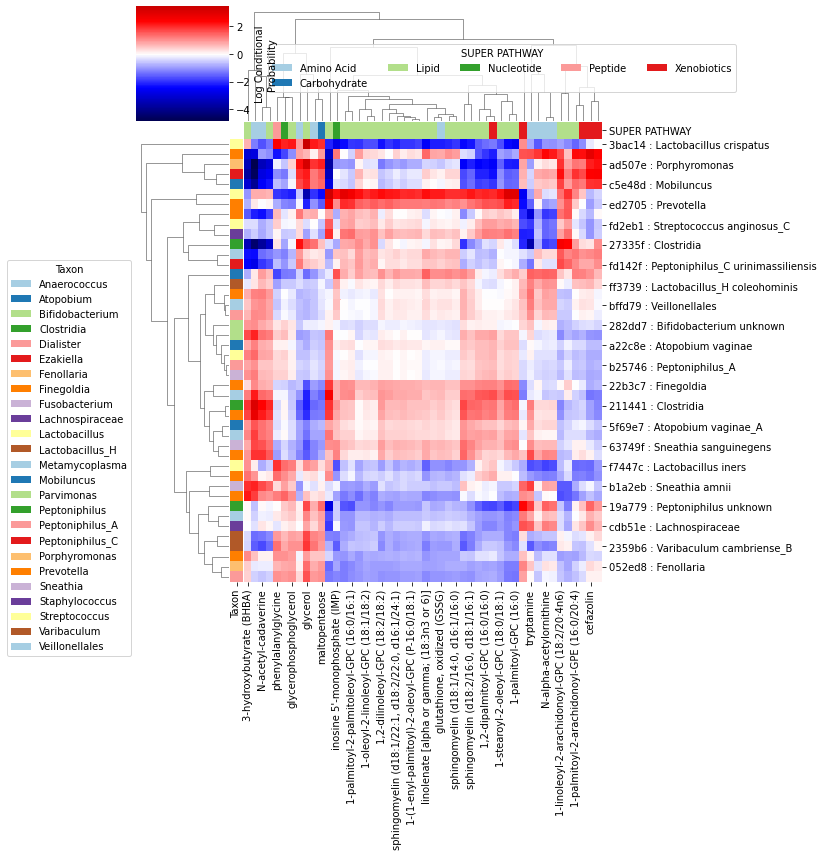

In [10]:
# todo adjust Taxon to Genus level
hotmap = mmvec.actions.heatmap(ranks=art_conditionals_t,
                               microbe_metadata=md_taxonomy.get_column(
                                   'Taxon'),
                               metabolite_metadata=metabolite_md.get_column(
                                   'SUPER PATHWAY'),
                               level=6,
                               x_labels=True,
                               y_labels=True,
                               margin_palette='Paired')

hotmap.visualization.save(os.path.join(output_dir, 'filtered-heatmap.qzv'))
